In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests

# 対象地域情報の読み込み

In [2]:
gdf_jcode = gpd.read_file('data/setup_2000_2020/jcode.geojson')
df_jcode_2000 = pd.read_csv('data/2000/jcode_2000.csv', dtype={'jcode_from': str, 'jcode_to': str})
list_jcode = df_jcode_2000['jcode_from'].to_list()
list_jcode_to = list(set(df_jcode_2000['jcode_from'].to_list()))

In [3]:
df_jcode_2000

,jcode_from,jcode_to,都道府県,政令市･郡･支庁･振興局等,市区町村
0,08220,08220,茨城県,NaN,つくば市
1,08482,08235,茨城県,筑波郡,伊奈町
2,08561,08224,茨城県,北相馬郡,守谷町
3,11203,11203,埼玉県,NaN,川口市
4,11204,11204,埼玉県,NaN,浦和市
...,...,...,...,...,...
108,14207,14207,神奈川県,NaN,茅ヶ崎市
109,14209,14209,神奈川県,NaN,相模原市
110,14213,14213,神奈川県,NaN,大和市
111,14215,14215,神奈川県,NaN,海老名市


# 地価情報の取得

In [4]:
# pd.read_excel('https://www.mlit.go.jp/totikensangyo/content/001733704.xls')
df_chika = pd.read_excel('sources/001733704.xls', sheet_name='価格推移表', header=0, skiprows=[1])
nayose = pd.read_csv('sources/chika_nayose.csv')

In [5]:
df_chika['Unnamed: 0'] = df_chika['Unnamed: 0'].astype(str)
df_chika['level'] = df_chika['Unnamed: 0'].str[0:1]
df_chika['jcode'] = df_chika['Unnamed: 0'].str[1:6]
df_chika['type'] = df_chika['Unnamed: 0'].str[-2:]
df_chika['name'] = df_chika['Unnamed: 1'].ffill()
df_chika['分類'] = df_chika['Unnamed: 2']
df_chika.loc[df_chika['jcode'] == "14150", "jcode"] = "14209" # 相模原市のjcodeを修正
df_chika = df_chika.drop(columns=['Unnamed: 0', 'Unnamed: 1','Unnamed: 2'])
df_chika = df_chika[[
    'level',   'jcode',   'type',    'name',    '分類',
    '昭和50年', '昭和51年', '昭和52年', '昭和53年', '昭和54年', '昭和55年', '昭和56年', '昭和57年',
    '昭和58年', '昭和59年', '昭和60年', '昭和61年', '昭和62年', '昭和63年', '平成元年', '平成2年',
    '平成3年',  '平成4年',  '平成5年',  '平成6年',  '平成7年',  '平成8年',  '平成9年',  '平成10年',
    '平成11年', '平成12年', '平成13年', '平成14年', '平成15年', '平成16年', '平成17年', '平成18年',
    '平成19年', '平成20年', '平成21年', '平成22年', '平成23年', '平成24年', '平成25年', '平成26年',
    '平成27年', '平成28年', '平成29年', '平成30年', '平成31年', '令和2年',  '令和3年',  '令和4年',
    '令和5年',  '令和6年'
]]

In [6]:
df_chika_res = df_chika[['jcode','分類','平成12年']].query('分類 == "住宅"').rename(columns={'平成12年':'res_price'})
df_chika_com = df_chika[['jcode','分類','平成12年']].query('分類 == "商業"').rename(columns={'平成12年':'com_price'})

df_chika_res = df_chika_res.query('jcode in @list_jcode')
df_chika_com = df_chika_com.query('jcode in @list_jcode')

In [7]:
# 2020年居住地平均価格を参考に、300,000円/坪で正規化
print('居住地価格平均値:', np.mean(df_chika_res['res_price'].to_numpy()))
print('居住地価格中央値:', np.median(df_chika_res['res_price'].to_numpy()))

居住地価格平均値: 302188.49557522126
居住地価格中央値: 250500.0


In [8]:
df_chika_res['q_i'] = df_chika_res['res_price']/300000
df_chika_com['Q_j'] = df_chika_com['com_price']/300000
print(df_chika_res['q_i'].mean())
print(df_chika_com['Q_j'].mean())

1.0072949852507374
2.221587878787879


In [9]:
df_q_i = df_chika_res[['jcode','q_i']].round(6).reset_index(drop=True)
df_Q_j = df_chika_com[['jcode','Q_j']].round(6).reset_index(drop=True)
df_Q_j.loc[df_Q_j['Q_j'].isnull(),'Q_j'] = df_q_i.loc[df_Q_j['Q_j'].isnull(),'q_i'] # Q_jがない場合はq_iで置き換える

In [10]:
df_Q_j

,jcode,Q_j
0,08220,0.596333
1,08482,0.211667
2,08561,0.438333
3,11203,1.776333
4,11204,1.926333
...,...,...
108,14205,1.933000
109,14207,1.597667
110,14213,1.401333
111,14215,1.511667


# 所得w_jの取得

In [11]:
# 所得w_jの取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
    'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
    'lang':'J',
    'statsDataId':'0000081782',
    # 'metaGetFlg':'N',
    'explanationGetFlg':'N',
    'annotationGetFlg':'N',
    'cdCat02':'001',
    # 'lvArea':'2-',
    'cdAreaFrom': '08000',
    'cdAreaTo': '14999',
}

res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 世帯の年間収入階級（８）、世帯の種類（２），住宅の所有の関係（５）、普通世帯数、市（６７１）・１３大都市の区（１５１）・一定規模以上の町村（２０８）
ヒット件数： 2583


[{'@id': 'cat01',
  '@name': '世帯の年間収入081231',
  'CLASS': [{'@code': '000', '@name': '総数（「不詳」を含む）', '@level': '1'},
   {'@code': '001', '@name': '\u3000２００万円未満', '@level': '1'},
   {'@code': '002', '@name': '\u3000２００\u3000～\u3000３００万円未満', '@level': '1'},
   {'@code': '003', '@name': '\u3000３００\u3000～\u3000４００', '@level': '1'},
   {'@code': '004', '@name': '\u3000４００\u3000～\u3000５００', '@level': '1'},
   {'@code': '005', '@name': '\u3000５００\u3000～\u3000７００', '@level': '1'},
   {'@code': '006', '@name': '\u3000７００\u3000～１，０００', '@level': '1'},
   {'@code': '007', '@name': '\u3000１，０００～１，５００', '@level': '1'},
   {'@code': '008', '@name': '\u3000１，５００万円以上', '@level': '1'}]},
 {'@id': 'cat02',
  '@name': '世帯の種類２081233',
  'CLASS': {'@code': '001', '@name': '総数', '@level': '1', '@unit': '世帯'}},
 {'@id': 'area',
  '@name': '市区一定規模080051',
  'CLASS': [{'@code': '08201', '@name': '水戸市', '@level': '1'},
   {'@code': '08202', '@name': '日立市', '@level': '1'},
   {'@code': '08203', '@name': '土浦市', '@

In [12]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

def parse_wage(x):
   if   x=='001': return 100
   elif x=='002': return 250
   elif x=='003': return 350
   elif x=='004': return 450
   elif x=='005': return 600
   elif x=='006': return 850
   elif x=='007': return 1250
   elif x=='008': return 2000
   else: return 0

def parse_num(x):
   if x=='-': return 0
   else: return int(x)

df['weight'] = df['@cat01'].apply(parse_wage)
df['num'] = df['$'].astype(int)
df['jcode'] = df['@area']


wm = lambda x: np.average(x, weights=df.loc[x.index, "num"]).round(2)
df_w_j = df.groupby(by='jcode').agg(w_j=("weight", wm)).loc[list_jcode_to].reset_index().sort_values('jcode')
df_w_j['w_j'] = (df_w_j['w_j']/300).round(6)
df_w_j

,jcode,w_j
24,08220,0.970733
106,08482,1.154167
81,08561,1.239167
70,11203,0.957567
87,11204,1.078267
...,...,...
69,14207,1.112867
61,14209,1.003167
56,14213,1.018700
3,14215,1.122900


# 通勤割合λ_ijの取得

In [13]:
From = '08000'
To = '14999'

URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000033350',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     # 'cdArea':','.join(list),
     # # 'cdCat02':','.join(list)
     # 'lvArea':'4-',
     'cdAreaFrom': From,
     'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdCat01From':From,
     'cdCat01To':To,
     }

res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： １５歳以上自宅外就業者・通学者数 （常住地）都道府県・市区町村、（従業地）市区町村
ヒット件数： 27755


[{'@id': 'cat01',
  '@name': '従業通学地030223',
  'CLASS': [{'@code': '08201', '@name': '水戸市', '@level': '4'},
   {'@code': '08202', '@name': '日立市', '@level': '4'},
   {'@code': '08203', '@name': '土浦市', '@level': '4'},
   {'@code': '08204', '@name': '古河市', '@level': '4'},
   {'@code': '08205', '@name': '石岡市', '@level': '4'},
   {'@code': '08206', '@name': '下館市', '@level': '4'},
   {'@code': '08207', '@name': '結城市', '@level': '4'},
   {'@code': '08208', '@name': '龍ケ崎市', '@level': '4'},
   {'@code': '08210', '@name': '下妻市', '@level': '4'},
   {'@code': '08211', '@name': '水海道市', '@level': '4'},
   {'@code': '08212', '@name': '常陸太田市', '@level': '4'},
   {'@code': '08214', '@name': '高萩市', '@level': '4'},
   {'@code': '08215', '@name': '北茨城市', '@level': '4'},
   {'@code': '08216', '@name': '笠間市', '@level': '4'},
   {'@code': '08217', '@name': '取手市', '@level': '4'},
   {'@code': '08218', '@name': '岩井市', '@level': '4'},
   {'@code': '08219', '@name': '牛久市', '@level': '4'},
   {'@code': '08220', '@

In [14]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_commute_ij = pd.DataFrame(0,columns=list_jcode,index=list_jcode)
for i in df.itertuples():
    if (i[1] not in list_jcode)|(i[3] not in list_jcode): continue
    if i[6] in ['-',None]: 
        df_commute_ij.at[i[3],i[1]]=0
    else: 
        if int(i[6]) > 100: df_commute_ij.at[i[3],i[1]]=int(i[6])

In [15]:
df_commute_ij

,08220,08482,08561,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
08220,60769,400,312,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
08482,1125,3596,827,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
08561,1005,463,8612,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11203,0,0,0,100952,10693,4489,418,635,909,2840,...,0,0,0,0,0,0,0,0,0,0
11204,0,0,0,11161,86874,13295,903,1739,4703,985,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0,0,0,0,0,0,0,0,0,0,...,133,0,0,2828,13558,40288,695,669,935,236
14209,0,0,0,0,0,0,0,0,0,0,...,1466,758,1678,345,2504,412,163126,5197,2607,5655
14213,0,0,0,0,0,0,0,0,0,0,...,322,391,463,548,5920,451,4134,40344,2054,3179
14215,0,0,0,0,0,0,0,0,0,0,...,210,108,240,183,1742,495,2047,2331,19418,1788


# 世帯あたり子供の数n_ijの取得

In [16]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000032965',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'00700',
     'cdCat02':'000',
     'cdCat03':','.join(['200','201','202']),
     'cdCat04':'000',
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To,
}

res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 国籍（２）、年齢各歳階級（１２３）、男女（３）、人口 市区町村、全域・人口集中地区の別
ヒット件数： 1773


[{'@id': 'cat01',
  '@name': '全域・集中の別030184',
  'CLASS': {'@code': '00700', '@name': '全域', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '国籍031121',
  'CLASS': {'@code': '000', '@name': '総数（外国，不詳を含む）', '@level': '1'}},
 {'@id': 'cat03',
  '@name': '年齢各歳１２３030798',
  'CLASS': [{'@code': '200',
    '@name': '0～4歳',
    '@level': '2',
    '@parentCode': 'T01'},
   {'@code': '201', '@name': '5～9歳', '@level': '2', '@parentCode': 'T01'},
   {'@code': '202', '@name': '10～14歳', '@level': '2', '@parentCode': 'T01'}]},
 {'@id': 'cat04',
  '@name': '男女031123',
  'CLASS': {'@code': '000', '@name': '総数', '@level': '1', '@unit': '人'}},
 {'@id': 'area',
  '@name': '県市区町村030172',
  'CLASS': [{'@code': '08000', '@name': '茨城県', '@level': '2'},
   {'@code': '08001', '@name': '茨城県市部', '@level': '3', '@parentCode': '08000'},
   {'@code': '08002', '@name': '茨城県郡部', '@level': '3', '@parentCode': '08000'},
   {'@code': '08201', '@name': '水戸市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08202', '@na

In [17]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_children_i = pd.DataFrame(0,index=list_jcode,columns=[0])
for i in df.itertuples():
    try: 
        if i[8] == '-': pass
        else: df_children_i.at[i[5],0] += int(i[8])
    except: pass

arr_children_ij = df_children_i.to_numpy() * df_commute_ij.to_numpy()/df_commute_ij.sum(axis=1).to_numpy().reshape(1,-1).T
df_children_ij = pd.DataFrame(arr_children_ij,index=list_jcode, columns=list_jcode)
df_children_ij = (df_children_ij).fillna(0)

In [18]:
df_children_ij

,08220,08482,08561,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
08220,27185.481303,178.943088,139.575609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
08482,686.598774,2194.674838,504.726388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
08561,865.217262,398.602579,7414.180159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11203,0.000000,0.000000,0.000000,49844.867835,5279.649455,2216.435650,206.386746,313.530104,448.817110,1402.244875,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11204,0.000000,0.000000,0.000000,6164.248676,47980.731071,7342.862302,498.729196,960.454121,2597.478857,544.018004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54.493456,0.000000,0.000000,1158.702952,5555.054678,16507.010095,284.759035,274.106179,383.093091,96.695154
14209,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,613.799575,317.367038,702.561860,144.448058,1048.399820,172.500290,68299.228876,2175.932055,1091.524893,2367.692086
14213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,123.699010,150.205941,177.865347,210.518812,2274.217822,173.255446,1588.110891,15498.487129,789.061386,1221.239604
14215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,94.398774,48.547941,107.884313,82.261789,783.060306,222.511396,920.163287,1047.826391,8728.739966,803.738133


# 交通費用の算出

In [19]:
gdf_gov = gpd.read_file('data/setup_2000_2020/gov_poi.geojson',dtypes={'jcode':str})

In [20]:
df_time = pd.read_csv('sources/e-2_H10.csv', header=3, encoding='CP932')
df_time.columns = ['origin','destination','発ゾーン','着ゾーン','鉄道','路線バス・都電','自動車','２輪車','自転車','徒歩','その他','合計']
df_time['発ゾーン'] = df_time['発ゾーン'].str.strip(':').str.translate(str.maketrans('０１２３４５６７８９', '0123456789'))
df_time['着ゾーン'] = df_time['着ゾーン'].str.strip(':').str.translate(str.maketrans('０１２３４５６７８９', '0123456789'))
ptcode = gdf_gov['H10'].tolist()
df_time = df_time[(df_time['発ゾーン'].isin(ptcode))&(df_time['着ゾーン'].isin(ptcode))]

In [21]:
df_time = df_time.merge(gdf_gov[['jcode','H10']], left_on='発ゾーン', right_on='H10', how='left').rename(columns={'jcode':'ori_jcode'}).drop(columns='H10')
df_time = df_time.merge(gdf_gov[['jcode','H10']], left_on='着ゾーン', right_on='H10', how='left').rename(columns={'jcode':'dst_jcode'}).drop(columns='H10')

df_time = df_time.sort_values(['ori_jcode', 'dst_jcode'])
df_time['鉄道'] = df_time['鉄道'].where(df_time['鉄道'] !=0.0, df_time[['路線バス・都電','自動車']].apply(lambda x: np.round(np.mean(x),2), axis=1))

In [52]:
df_time_ij = (df_time.pivot_table(values='鉄道', index='ori_jcode', columns='dst_jcode', fill_value=540)/(60*24)).round(6)

In [53]:
df_time_ij

dst_jcode,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
08220,0.003500,0.013069,0.006569,0.375000,0.375000,0.375000,0.375000,0.118056,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08224,0.012458,0.012951,0.007243,0.069444,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08235,0.006264,0.007486,0.016771,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11203,0.375000,0.072917,0.375000,0.021944,0.028264,0.031035,0.031250,0.036979,0.027375,0.028292,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11204,0.375000,0.375000,0.375000,0.029632,0.068896,0.018868,0.062069,0.042056,0.022014,0.012153,...,0.045139,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.083333,0.086806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.375000,0.375000,0.375000,0.375000,0.375000,0.086806,0.013889,0.375000,0.375000,0.375000,...,0.027778,0.062500,0.059722,0.053146,0.026097,0.032021,0.075326,0.050076,0.041514,0.055556
14209,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.065326,0.375000,0.375000,0.375000,...,0.050611,0.058861,0.031556,0.020833,0.026125,0.066056,0.025229,0.043062,0.045382,0.036639
14213,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.037507,0.036208,0.034556,0.054007,0.031549,0.049181,0.042410,0.017569,0.036021,0.031854


In [24]:
df_time_ij_sim = df_time_ij
df_time_ij_sim.loc['13101':'13123',:] = df_time_ij_sim.loc['13101':'13123',:]*0.50
df_time_ij_sim.loc[:,'13101':'13123'] = df_time_ij_sim.loc[:,'13101':'13123']*0.50
df_time_ij_sim.loc['13101':'13123','13101':'13123'] = df_time_ij_sim.loc['13101':'13123','13101':'13123']/0.50
df_time_ij_sim

dst_jcode,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
08220,0.003500,0.013069,0.006569,0.375000,0.375000,0.375000,0.375000,0.118056,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08224,0.012458,0.012951,0.007243,0.069444,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08235,0.006264,0.007486,0.016771,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11203,0.375000,0.072917,0.375000,0.021944,0.028264,0.031035,0.031250,0.036979,0.027375,0.028292,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11204,0.375000,0.375000,0.375000,0.029632,0.068896,0.018868,0.062069,0.042056,0.022014,0.012153,...,0.045139,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.083333,0.086806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.375000,0.375000,0.375000,0.375000,0.375000,0.086806,0.013889,0.375000,0.375000,0.375000,...,0.027778,0.062500,0.059722,0.053146,0.026097,0.032021,0.075326,0.050076,0.041514,0.055556
14209,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.065326,0.375000,0.375000,0.375000,...,0.050611,0.058861,0.031556,0.020833,0.026125,0.066056,0.025229,0.043062,0.045382,0.036639
14213,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.037507,0.036208,0.034556,0.054007,0.031549,0.049181,0.042410,0.017569,0.036021,0.031854


運賃の参考
初乗り:　130円 (第84条)
距離運賃: 16.8円/km (第77条)
https://www.desktoptetsu.com/ryoki/ryokikaitei_jre_2.htm

In [54]:
gdf_gov = gdf_gov.to_crs(epsg=6677)
list_gov = gdf_gov['jcode'].to_list()
distance_matrix = gdf_gov.geometry.apply(lambda x: gdf_gov.distance(x)).values
distance_matrix = np.where(distance_matrix/1000 > 130/16.8, distance_matrix/1000*16.8, 130)
distance_matrix = distance_matrix * (22*12) / 3000000
distance_matrix = np.round(distance_matrix, 5)
df_cost_ij = pd.DataFrame(distance_matrix,index=list_gov, columns=list_gov)

In [55]:
df_cost_ij

,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
08220,0.01144,0.02553,0.02047,0.06523,0.06812,0.06640,0.09350,0.06670,0.06841,0.05569,...,0.10251,0.10486,0.10956,0.14401,0.14508,0.15230,0.12602,0.12803,0.13900,0.13233
08224,0.02553,0.01144,0.01144,0.04099,0.04650,0.04685,0.07209,0.05115,0.04793,0.03070,...,0.07754,0.07964,0.08481,0.11851,0.11955,0.12687,0.10182,0.10285,0.11391,0.10737
08235,0.02047,0.01144,0.01144,0.04891,0.05491,0.05527,0.08047,0.05923,0.05636,0.03828,...,0.08485,0.08667,0.09227,0.12432,0.12576,0.13346,0.10954,0.10990,0.12104,0.11462
11203,0.06523,0.04099,0.04891,0.01144,0.01371,0.02059,0.03417,0.03286,0.01811,0.01144,...,0.03771,0.04079,0.04442,0.08358,0.08299,0.08873,0.06090,0.06347,0.07419,0.06734
11204,0.06812,0.04650,0.05491,0.01371,0.01144,0.01144,0.02563,0.02030,0.01144,0.02218,...,0.04113,0.04546,0.04613,0.08984,0.08808,0.09227,0.05983,0.06619,0.07605,0.06885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.15230,0.12687,0.13346,0.08873,0.09227,0.09856,0.07688,0.10852,0.09495,0.09685,...,0.05140,0.04794,0.04629,0.01924,0.01164,0.01144,0.03919,0.02619,0.01856,0.02539
14209,0.12602,0.10182,0.10954,0.06090,0.05983,0.06468,0.03956,0.07280,0.06140,0.07126,...,0.02652,0.02768,0.01853,0.04747,0.04129,0.03919,0.01144,0.01785,0.02064,0.01435
14213,0.12803,0.10285,0.10990,0.06347,0.06619,0.07239,0.05122,0.08236,0.06879,0.07234,...,0.02577,0.02323,0.02011,0.03006,0.02477,0.02619,0.01785,0.01144,0.01144,0.01144
14215,0.13900,0.11391,0.12104,0.07419,0.07605,0.08186,0.05886,0.09120,0.07835,0.08333,...,0.03653,0.03438,0.03005,0.02956,0.02219,0.01856,0.02064,0.01144,0.01144,0.01144


# 商業地比率の算出



住宅件数と事業所数から算出
- 令和3年延べ面積比率（区別）
  - https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_r3/tochi_r3_67.csv
- 事業所数
  - https://api.e-stat.go.jp/rest/3.0/app/getStatsData?cdCat01=A%2CB%2CC%2CD%2CE%2CF%2CG%2CH%2CI%2CJ%2CK%2CL%2CM%2CN%2CO%2CP%2CQ%2CR&cdTab=102-2021&cdArea=13101%2C13102%2C13103%2C13104%2C13105%2C13106%2C13107%2C13108%2C13109%2C13110%2C13111%2C13112%2C13113%2C13114%2C13115%2C13116%2C13117%2C13118%2C13119%2C13120%2C13121%2C13122%2C13123&appId=&lang=J&statsDataId=0004005684&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0
- 
- 住宅数
  - https://api.e-stat.go.jp/rest/3.0/app/getStatsData?cdCat01=1%2C2%2C3%2C4&cdCat02=00&cdArea=13101%2C13102%2C13103%2C13104%2C13105%2C13106%2C13107%2C13108%2C13109%2C13110%2C13111%2C13112%2C13113%2C13114%2C13115%2C13116%2C13117%2C13118%2C13119%2C13120%2C13121%2C13122%2C13123&cdCat03=0&appId=&lang=J&statsDataId=0003355607&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0
- 

In [27]:
df_weight = pd.read_excel('https://www.toukei.metro.tokyo.lg.jp/tnenkan/2001/01qytia0032.xls', header=13, skiprows=[14,15,16,40,41,42,43,44,45,75,76,77,78,79,80,81,82,83] ,usecols=[2,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32])

- Ａ農業 : o
- Ｂ林業 : o
- Ｃ漁業 : o
- Ｄ鉱業 : なし
- Ｅ建設業 : なし
- Ｆ製造業 : lm
- Ｇ電気・ガス・熱供給・水道業 : d
- Ｈ運輸・通信業 : n
- Ｉ卸売・小売業，飲食店 : efghi
- Ｊ金融・保険業 : efghi
- Ｋ不動産業 : efghi
- Ｌサービス業 : efghi
- 一戸建て : j
- その他住宅 : k
- 国・地方公共団体 : abc

- abc
  - a官公庁施設
  - b教育文化施設
  - c厚生医療施設
- d
  - d供給処理施設
- efghi
  - e事務所建築物
  - f専用商業施設
  - g住商併用施設
  - h宿泊遊興施設
  - iスポーツ興業施設
- j
  - j独立住宅
- k
  - k集合住宅
- lm
  - l専用工場
  - m住居併用工場
- n
  - n倉庫・運輸関係施設
- o
  - o農林漁業施設

In [28]:
df_weight.columns = ['市区町村','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']
df_weight['市区町村'] = df_weight['市区町村'].str.replace('　','')
df_weight = df_weight.merge(df_jcode_2000.query('都道府県=="東京都"')[['市区町村','jcode_from']], on='市区町村', how='left')
df_weight = df_weight.query('jcode_from in @list_jcode').reset_index(drop=True)
df_weight.head()

,市区町村,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,jcode_from
0,千代田区,10.1,8.1,1.4,0.1,58.6,2.6,6.4,5.5,0.5,1.0,3.6,0.2,0.2,1.9,0.0,13101
1,中央区,2.5,2.3,1.1,1.1,59.9,4.8,6.1,3.4,0.2,1.8,11.1,0.7,0.6,4.3,0.0,13102
2,港区,3.3,5.4,1.3,0.6,44.4,1.8,5.9,7.4,0.6,4.0,20.1,1.0,0.5,3.7,0.0,13103
3,新宿区,2.3,7.3,2.7,0.5,28.0,3.9,7.7,5.8,1.2,11.3,26.5,1.2,0.9,0.8,0.0,13104
4,文京区,1.3,16.4,3.0,0.1,16.1,0.5,8.3,3.1,1.9,17.2,27.6,1.6,1.9,1.1,0.0,13105


In [29]:
df_weight_i= pd.DataFrame(
    0,
    index=list_jcode,
    columns=['abc','d','efghi','j','k','lm','n','o']
)

In [30]:
import statsmodels.api as sm
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000041316',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     # 'cdCat01':'A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R',
     # 'cdTab':'102-2021',
     # 'cdArea':','.join(jcode),
     'cdCat02':'001',
     # 'cdCat03':'000',
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 産業大分類（１８）、従業者規模（１０）、経営組織（４）、事業所数・従業者数（民営）、都道府県・市区町村（３４２９）
ヒット件数： 9288


[{'@id': 'cat01',
  '@name': '産業大分類１８040362',
  'CLASS': [{'@code': '001', '@name': 'Ａ～Ｌ\u3000全産業', '@level': '1'},
   {'@code': '002', '@name': 'Ａ～Ｃ\u3000農林漁業', '@level': '1'},
   {'@code': '003', '@name': 'Ａ\u3000農業', '@level': '1'},
   {'@code': '004', '@name': 'Ｂ\u3000林業', '@level': '1'},
   {'@code': '005', '@name': 'Ｃ\u3000漁業', '@level': '1'},
   {'@code': '006', '@name': 'Ｄ～Ｌ\u3000非農林漁業', '@level': '1'},
   {'@code': '007', '@name': 'Ｄ\u3000鉱業', '@level': '1'},
   {'@code': '008', '@name': 'Ｅ\u3000建設業', '@level': '1'},
   {'@code': '009', '@name': 'Ｆ\u3000製造業', '@level': '1'},
   {'@code': '010', '@name': 'Ｇ\u3000電気・ガス・熱供給・水道業', '@level': '1'},
   {'@code': '011', '@name': 'Ｈ\u3000運輸・通信業', '@level': '1'},
   {'@code': '012', '@name': 'Ｉ\u3000卸売・小売業，飲食店', '@level': '1'},
   {'@code': '013', '@name': '\u3000４８～５３\u3000卸売業', '@level': '1'},
   {'@code': '014', '@name': '\u3000５４～５９\u3000小売業', '@level': '1'},
   {'@code': '015', '@name': '\u3000６０～６１\u3000飲食店', '@level': '1'},
   {'

In [31]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
for i in df.itertuples():
    try: 
        if i[6] == '-': continue
        else: 
            if   i[1]=='003': df_weight_i.at[i[3],'o'] += int(i[6]) #Ａ農業 : o
            elif i[1]=='004': df_weight_i.at[i[3],'o'] += int(i[6]) #Ｂ林業 : o
            elif i[1]=='005': df_weight_i.at[i[3],'o'] += int(i[6]) #Ｃ漁業 : o
            elif i[1]=='007': continue #Ｄ鉱業 : なし
            elif i[1]=='008': continue #Ｅ建設業 : なし
            elif i[1]=='009': df_weight_i.at[i[3],'lm'] += int(i[6]) #Ｆ製造業 : lm
            elif i[1]=='010': df_weight_i.at[i[3],'d'] += int(i[6]) #Ｇ電気・ガス・熱供給・水道業 : d
            elif i[1]=='011': df_weight_i.at[i[3],'n'] += int(i[6]) #Ｈ運輸・通信業 : n
            elif i[1]=='012': df_weight_i.at[i[3],'efghi'] += int(i[6]) #Ｉ卸売・小売業，飲食店 : efghi
            elif i[1]=='016': df_weight_i.at[i[3],'efghi'] += int(i[6]) #Ｊ金融・保険業 : efghi
            elif i[1]=='017': df_weight_i.at[i[3],'efghi'] += int(i[6]) #Ｋ不動産業 : efghi
            elif i[1]=='018': df_weight_i.at[i[3],'efghi'] += int(i[6]) #Ｌサービス業 : efghi
    except: continue

In [32]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000081637',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'000',
     'cdCat02':','.join(['002','005','008','013']),
     # 'cdCat03':'0',
     # 'cdArea':','.join(jcode),
     # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 建物の構造（３）、住宅の建て方（４），建物の階数（４）、住宅数、市（６７１）・１３大都市の区（１５１）・一定規模以上の町村（２０８）
ヒット件数： 1148


[{'@id': 'cat01',
  '@name': '建物の構造３080906',
  'CLASS': {'@code': '000', '@name': '総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '住宅の建て方４081194',
  'CLASS': [{'@code': '002',
    '@name': '\u3000一戸建',
    '@level': '1',
    '@unit': '戸'},
   {'@code': '005', '@name': '\u3000長屋建', '@level': '1', '@unit': '戸'},
   {'@code': '008', '@name': '\u3000共同住宅', '@level': '1', '@unit': '戸'},
   {'@code': '013', '@name': '\u3000その他', '@level': '1', '@unit': '戸'}]},
 {'@id': 'area',
  '@name': '市区一定規模080051',
  'CLASS': [{'@code': '08201', '@name': '水戸市', '@level': '1'},
   {'@code': '08202', '@name': '日立市', '@level': '1'},
   {'@code': '08203', '@name': '土浦市', '@level': '1'},
   {'@code': '08204', '@name': '古河市', '@level': '1'},
   {'@code': '08205', '@name': '石岡市', '@level': '1'},
   {'@code': '08206', '@name': '下館市', '@level': '1'},
   {'@code': '08207', '@name': '結城市', '@level': '1'},
   {'@code': '08208', '@name': '龍ケ崎市', '@level': '1'},
   {'@code': '08210', '@name': '下妻市', '@level': '1'

In [33]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
for i in df.itertuples():
    try: 
        if i[6] == '-': pass
        else: 
            if i[2]=='002': df_weight_i.at[i[3],'j'] += int(i[6]) # 一戸建て : j
            else: df_weight_i.at[i[3],'k'] += int(i[6]) # その他住宅 : k
    except: pass

In [34]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000040993',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'001',
     'cdCat02':'044',
     # 'cdCat03':'000',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 産業大分類（１３），経営組織（３）・従業者規模（６）・事業所数，従業上の地位（６）・男女（３）・従業者数，都道府県・市区町村
ヒット件数： 593


[{'@id': 'cat01',
  '@name': '産業大分類１３040301',
  'CLASS': {'@code': '001', '@name': 'Ａ～Ｍ\u3000全産業', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '経営従規模地位040302',
  'CLASS': {'@code': '044',
   '@name': '国・地方公共団体\u3000事業者数',
   '@level': '1',
   '@unit': '事業所'}},
 {'@id': 'area',
  '@name': '県市区町村040056',
  'CLASS': [{'@code': '08000', '@name': '茨城県', '@level': '1'},
   {'@code': '08001', '@name': '茨城県市部', '@level': '2', '@parentCode': '08000'},
   {'@code': '08002', '@name': '茨城県郡部', '@level': '2', '@parentCode': '08000'},
   {'@code': '08201', '@name': '水戸市', '@level': '2', '@parentCode': '08000'},
   {'@code': '08202', '@name': '日立市', '@level': '2', '@parentCode': '08000'},
   {'@code': '08203', '@name': '土浦市', '@level': '2', '@parentCode': '08000'},
   {'@code': '08204', '@name': '古河市', '@level': '2', '@parentCode': '08000'},
   {'@code': '08205', '@name': '石岡市', '@level': '2', '@parentCode': '08000'},
   {'@code': '08206', '@name': '下館市', '@level': '2', '@parentCode': '08000'},
   

In [35]:
df =  pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
for i in df.itertuples():
    try: 
        if i[6] == '-': pass
        else: 
            df_weight_i.at[i[3],'abc'] += int(i[6])
    except: pass

In [36]:
df_weight_i

,abc,d,efghi,j,k,lm,n,o
08220,301,5,4836,26470,29490,426,144,22
08482,30,0,405,7400,10,86,16,0
08561,52,2,1126,12070,2500,176,39,4
11203,296,2,13880,69130,98980,5409,542,11
11204,333,7,12455,72160,99010,1342,305,4
...,...,...,...,...,...,...,...,...
14207,117,0,5409,42740,33160,374,91,8
14209,366,4,17451,92300,126840,2372,490,18
14213,140,3,6866,32210,44650,720,156,5
14215,79,0,2947,20080,18980,319,139,5


In [37]:
df_weight_i['all'] = df_weight_i['abc'] + df_weight_i['d'] + df_weight_i['efghi'] + df_weight_i['j'] + df_weight_i['k'] + df_weight_i['lm'] + df_weight_i['n'] + df_weight_i['o']
df_weight_i['abc'] = df_weight_i['abc'] / df_weight_i['all']
df_weight_i['d'] = df_weight_i['d'] / df_weight_i['all']
df_weight_i['efghi'] = df_weight_i['efghi'] / df_weight_i['all']
df_weight_i['j'] = df_weight_i['j'] / df_weight_i['all']
df_weight_i['k'] = df_weight_i['k'] / df_weight_i['all']
df_weight_i['lm'] = df_weight_i['lm'] / df_weight_i['all']
df_weight_i['n'] = df_weight_i['n'] / df_weight_i['all']
df_weight_i['o'] = df_weight_i['o'] / df_weight_i['all']

In [38]:
tokyo = df_weight['jcode_from'].to_list()
df_weight_tokyo = df_weight_i.reset_index(names='jcode').query('jcode in @tokyo').reset_index()
df_weight_others = df_weight_i.reset_index(names='jcode').query('jcode not in @tokyo').reset_index()

In [39]:
abc_res   = sm.OLS((df_weight['a']+df_weight['b']+df_weight['c']), df_weight_tokyo['abc']).fit()
d_res     = sm.OLS((df_weight['d']), df_weight_tokyo['d']).fit()
efghi_res = sm.OLS((df_weight['e']+df_weight['f']+df_weight['g']+df_weight['h']+df_weight['i']), df_weight_tokyo['efghi']).fit()
j_res     = sm.OLS((df_weight['j']), df_weight_tokyo['j']).fit()
k_res     = sm.OLS((df_weight['k']), df_weight_tokyo['k']).fit()
lm_res    = sm.OLS((df_weight['l']+df_weight['m']), df_weight_tokyo['lm']).fit()
n_res     = sm.OLS((df_weight['n']), df_weight_tokyo['n']).fit()
o_res     = sm.OLS((df_weight['o']), df_weight_tokyo['o']).fit()

In [40]:
df_floorparam = pd.DataFrame(
    [
        abc_res.params['abc'],
        d_res.params['d'],
        efghi_res.params['efghi'],
        j_res.params['j'],
        k_res.params['k'],
        lm_res.params['lm'],
        n_res.params['n'],
        o_res.params['o']
    ],
    columns = ['param'],
    index = ['abc','d','efghi','j','k','lm','n','o'],
)
params = df_floorparam.to_dict()['param']
df_floorparam.to_csv('sources/floorspace.csv')

In [41]:
df_weight_tokyo['com_ratio'] = df_weight[['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm','n', 'o']].sum(axis=1)
df_weight_tokyo['res_ratio'] = df_weight[['j', 'k']].sum(axis=1)
df_weight_tokyo['theta_i']   = df_weight_tokyo['com_ratio']/(df_weight_tokyo['com_ratio']+df_weight_tokyo['res_ratio'] )

df_weight_others['com_ratio'] = (df_weight_others[['abc','d','efghi','lm','n','o']]*[params['abc'], params['d'], params['efghi'], params['lm'], params['n'], params['o']]).sum(axis=1)
df_weight_others['res_ratio'] = (df_weight_others[['j','k']]*[params['j'], params['k']]).sum(axis=1)
df_weight_others['theta_i']   =  df_weight_others['com_ratio']/(df_weight_others['com_ratio']+df_weight_others['res_ratio'])

df_theta = pd.concat([df_weight_others,df_weight_tokyo]).sort_values('jcode').reset_index()
df_theta_i = df_theta[['jcode','theta_i']].round(6)

In [42]:
df_theta_i

,jcode,theta_i
0,08220,0.335343
1,08482,0.210436
2,08561,0.249935
3,11203,0.288958
4,11204,0.229544
...,...,...
108,14207,0.194293
109,14209,0.239691
110,14213,0.252956
111,14215,0.233351


# その他の指標

In [43]:
df_p_i = pd.DataFrame({
    'jcode': list_jcode,
    'p_i':1
})

In [44]:
df_param = pd.DataFrame({
    'alpha': [0.8],
    'gamma': [0.375],
    'psi': [0.25],
    'beta_cns': [0.6],
    'beta_flr': [0.2], 
    'beta_chd': [0.2]
})

In [45]:
df_scaler = pd.DataFrame({
    'T': [1],
    'L': [0.66],
    'N': [np.sum(df_commute_ij.to_numpy())]
})

# 対象年度のマトリックスから、対象地域コードに置き換えてAggregateする

In [46]:
def agg_sum_df(df):
    df_ij = df.merge(df_jcode_2000[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to')
    df_ij = df_ij.T.merge(df_jcode_2000[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to').T
    df_ij = df_ij.groupby(df_ij.index).sum().T.groupby(df_ij.index).sum().T
    return df_ij

def agg_mean_df(df):
    df_ij = df.merge(df_jcode_2000[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to')
    df_ij = df_ij.T.merge(df_jcode_2000[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to').T
    df_ij = df_ij.groupby(df_ij.index).mean().T.groupby(df_ij.index).mean().T
    return df_ij

In [47]:
df_commute_ij = agg_sum_df(df_commute_ij)
df_children_ij = agg_sum_df(df_children_ij)
df_n_ij = (df_children_ij/df_commute_ij).fillna(0).round(6)
df_Pi_ij = (df_commute_ij/np.sum(df_commute_ij.to_numpy())).round(9)

# データの保存

In [48]:
df_merged = df_jcode_2000.merge(df_w_j, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_q_i, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_Q_j, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_p_i, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_theta_i, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.groupby(by='jcode_to').agg({'w_j':'mean','q_i':'mean','Q_j':'mean','p_i':'mean','theta_i':'mean'}).reset_index(names='jcode')

In [56]:
df_scaler.to_csv('data/2000/scaler.csv', index=False)
df_param.to_csv('data/2000/param.csv', index=False)

df_merged[['jcode']].to_csv('data/2000/jcode.csv')
df_merged[['jcode','w_j']].to_csv('data/2000/w_j.csv', index=False)
df_merged[['jcode','p_i']].to_csv('data/2000/p_i.csv', index=False)
df_merged[['jcode','q_i']].to_csv('data/2000/q_i.csv', index=False)
df_merged[['jcode','Q_j']].to_csv('data/2000/Q_j.csv', index=False)
df_merged[['jcode','theta_i']].to_csv('data/2000/theta_i.csv', index=False)

df_Pi_ij.to_csv('data/2000/Pi_ij.csv')
df_n_ij.to_csv('data/2000/n_ij.csv')
df_time_ij.to_csv('data/2000/t_ij.csv')
df_cost_ij.to_csv('data/2000/tau_ij.csv')

# 可視化

In [81]:
# 通勤人数の集計
df_commute_ij_agg = pd.DataFrame({
    'jcode': df_commute_ij.index,
    'residents': df_commute_ij.sum(axis=1, numeric_only=True).to_numpy(),
    'workers': df_commute_ij.sum(axis=0, numeric_only=True).to_numpy()
})

# 子供の数の集計
df_children_ij_agg = pd.DataFrame({
    'jcode': df_children_ij.index,
    'children_i': df_children_ij.sum(axis=1, numeric_only=True).to_numpy(),
    'children_j': df_children_ij.sum(axis=0, numeric_only=True).to_numpy(),
})

# 子供の数の平均
df_n_ij_agg = pd.DataFrame({
    'jcode': df_n_ij.index,
    'n_i_ave': df_n_ij[df_n_ij != 0].mean(axis=1, numeric_only=True).to_numpy(),
    'n_j_ave': df_n_ij[df_n_ij != 0].mean(axis=0, numeric_only=True).to_numpy(),
})

df_merged = df_merged.merge(df_commute_ij_agg, left_on='jcode_to', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_children_ij_agg, left_on='jcode_to', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_n_ij_agg, left_on='jcode_to', right_on='jcode', how='left').drop(columns=['jcode'])

In [82]:
gdf = gpd.read_file('data/setup_2000_2020/jcode.geojson')
gdf['jcode'] = gdf['jcode'].astype(str)
gdf = gdf.merge(df_merged, left_on='jcode', right_on='jcode_to', how='left').drop(columns=['jcode_to'])

In [74]:
from libs_QSM.Plot_gdf import plot_gdf

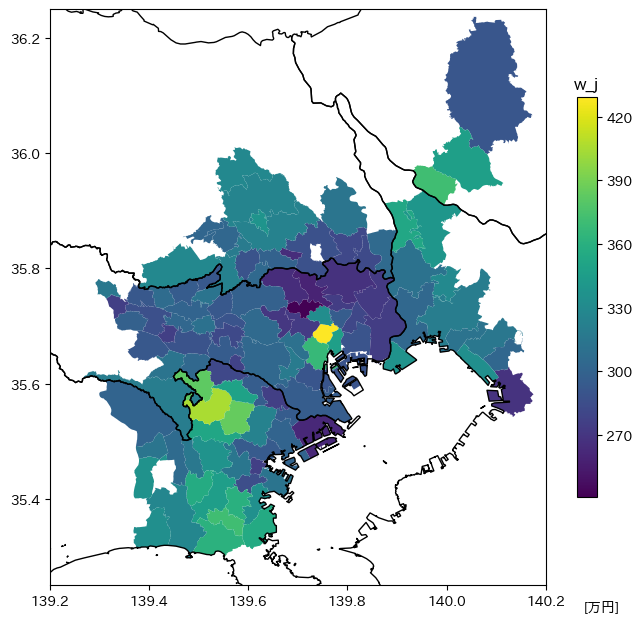

In [75]:
plot_gdf(gdf, '2000', 'w_j', '[万円]', lambda x, pos: int(x*300))

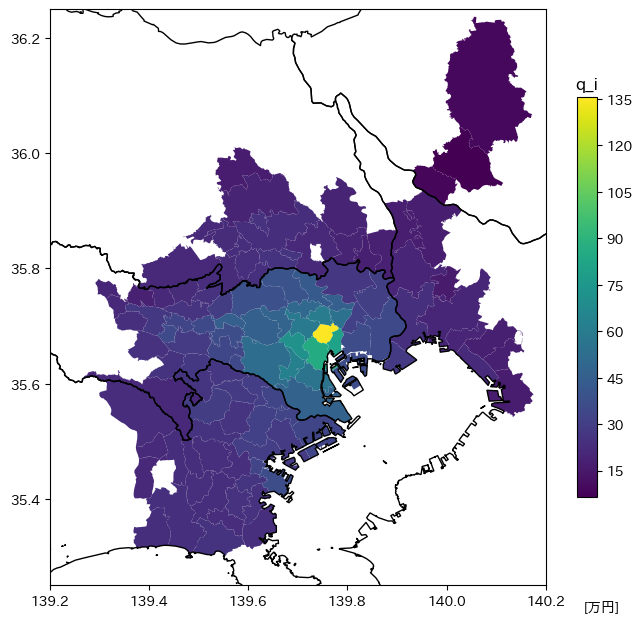

In [76]:
plot_gdf(gdf, '2000', 'q_i', '[万円]', lambda x, pos: int(x*30))

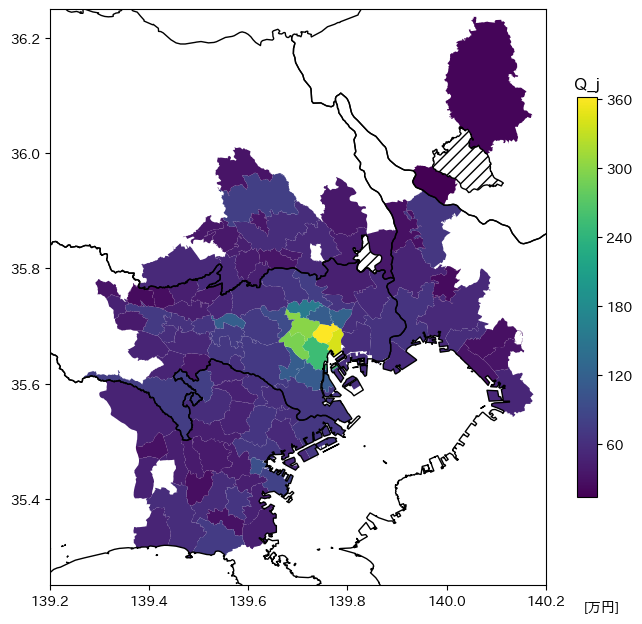

In [77]:
plot_gdf(gdf, '2000', 'Q_j', '[万円]', lambda x, pos: int(x*30))

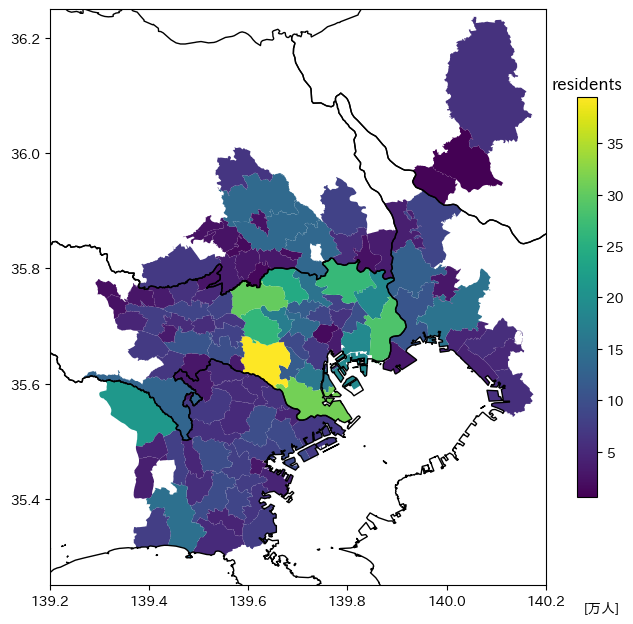

In [84]:
plot_gdf(gdf, '2000', 'residents', '[万人]', lambda x, pos: int(x/10000))

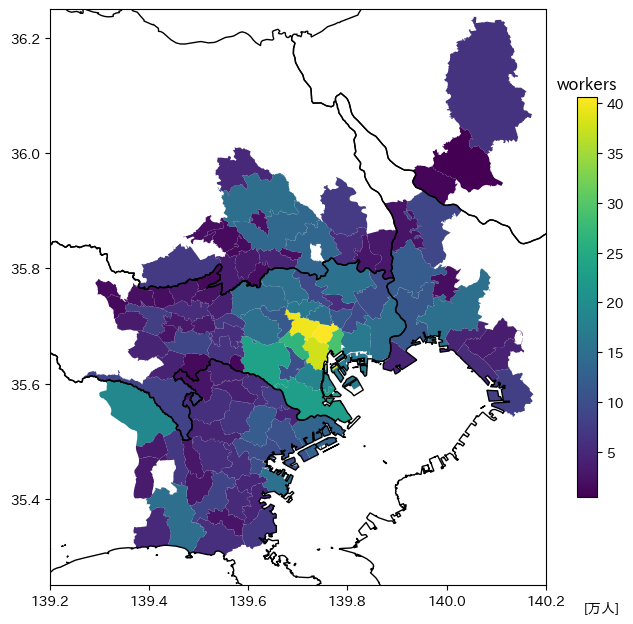

In [85]:
plot_gdf(gdf, '2000', 'workers', '[万人]', lambda x, pos: int(x/10000))

In [152]:
gdf['children_j'].std()

21149.040257791257

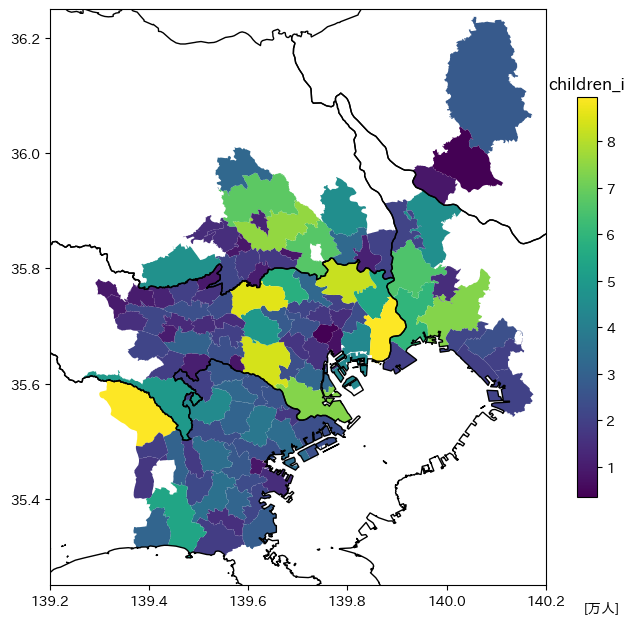

In [86]:
plot_gdf(gdf, '2000', 'children_i', '[万人]', lambda x, pos: int(x/10000))

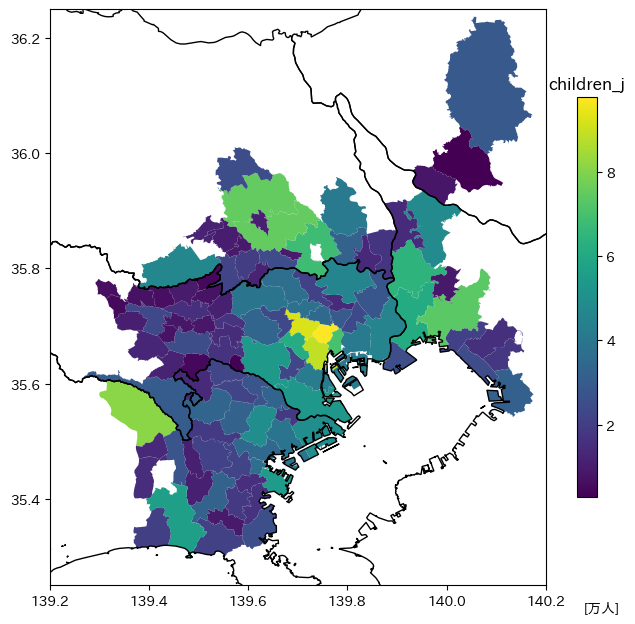

In [87]:
plot_gdf(gdf, '2000', 'children_j', '[万人]', lambda x, pos: int(x/10000))

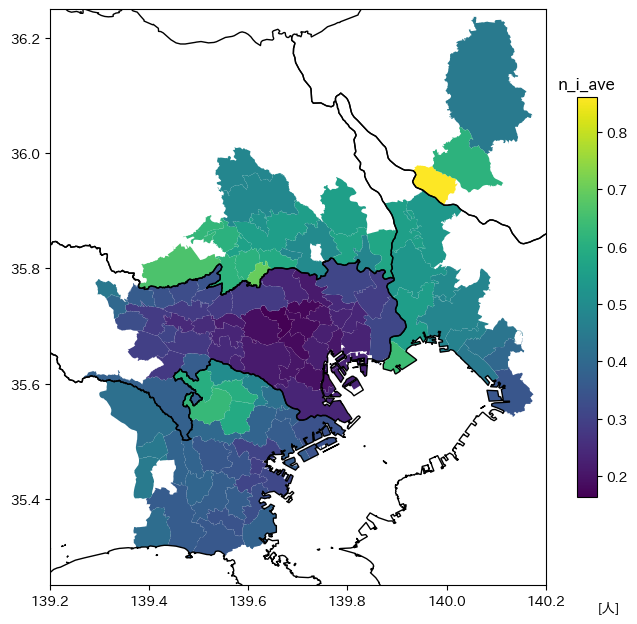

In [106]:
plot_gdf(gdf, '2000', 'n_i_ave', '[人]', lambda x, pos: x.round(2))

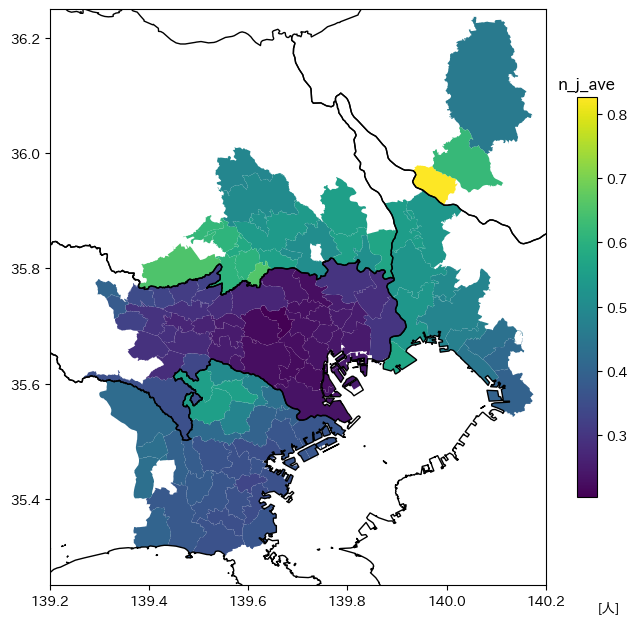

In [107]:
plot_gdf(gdf, '2000', 'n_j_ave', '[人]', lambda x, pos: x.round(2))

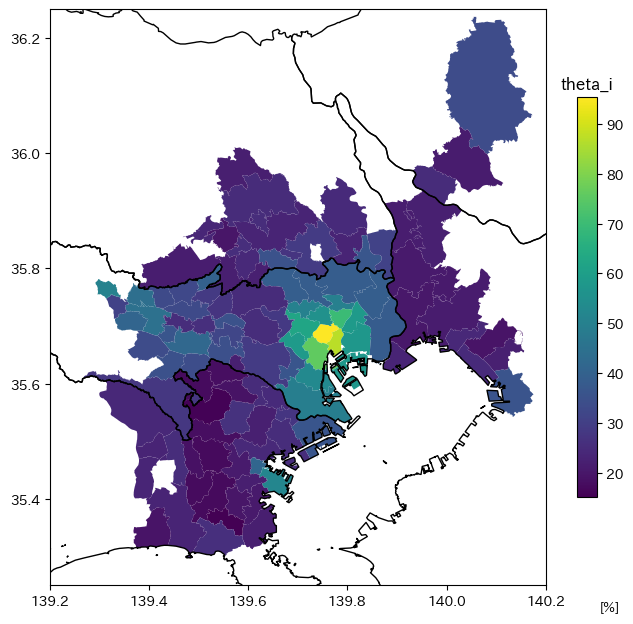

In [90]:
plot_gdf(gdf, '2000', 'theta_i', '[%]', lambda x, pos: int(x*100))